To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
<a href="https://unsloth.ai/"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
<a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
<a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://docs.unsloth.ai/get-started/installing-+-updating).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save)


### News

Unsloth now supports Text-to-Speech (TTS) models. Read our [guide here](https://docs.unsloth.ai/basics/text-to-speech-tts-fine-tuning).

Read our **[Qwen3 Guide](https://docs.unsloth.ai/basics/qwen3-how-to-run-and-fine-tune)** and check out our new **[Dynamic 2.0](https://docs.unsloth.ai/basics/unsloth-dynamic-2.0-ggufs)** quants which outperforms other quantization methods!

Visit our docs for all our [model uploads](https://docs.unsloth.ai/get-started/all-our-models) and [notebooks](https://docs.unsloth.ai/get-started/unsloth-notebooks).


### Installation

In [1]:
#!pip install unsloth

### Unsloth

In [1]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 4096 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 15 trillion tokens model 2x faster!
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # We also uploaded 4bit for 405b!
    "unsloth/Mistral-Nemo-Base-2407-bnb-4bit", # New Mistral 12b 2x faster!
    "unsloth/Mistral-Nemo-Instruct-2407-bnb-4bit",
    "unsloth/mistral-7b-v0.3-bnb-4bit",        # Mistral v3 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.6.2: Fast Llama patching. Transformers: 4.52.4.
   \\   /|    NVIDIA GeForce RTX 4090. Num GPUs = 2. Max memory: 23.51 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.9. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

<a name="Data"></a>
### Data Prep
We now use the Alpaca dataset from [yahma](https://huggingface.co/datasets/yahma/alpaca-cleaned), which is a filtered version of 52K of the original [Alpaca dataset](https://crfm.stanford.edu/2023/03/13/alpaca.html). You can replace this code section with your own data prep.

**[NOTE]** To train only on completions (ignoring the user's input) read TRL's docs [here](https://huggingface.co/docs/trl/sft_trainer#train-on-completions-only).

**[NOTE]** Remember to add the **EOS_TOKEN** to the tokenized output!! Otherwise you'll get infinite generations!

If you want to use the `llama-3` template for ShareGPT datasets, try our conversational [notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Alpaca.ipynb)

For text completions like novel writing, try this [notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Mistral_(7B)-Text_Completion.ipynb).

In [2]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instruction = "Classify the following medical transcription into the correct medical specialty."
    inputs = examples["transcription"]
    outputs = examples["medical_specialty"]

    texts = [
        alpaca_prompt.format(instruction, input_, output_) + EOS_TOKEN
        for input_, output_ in zip(inputs, outputs)
    ]
    return {"text": texts}

from datasets import load_dataset, DatasetDict
# Full data 로드
full_dataset = load_dataset("hpe-ai/medical-cases-classification-tutorial", split="train+validation+test")
# shuffle
full_dataset = full_dataset.shuffle(seed=42)
# prompt formatting
full_dataset = full_dataset.map(formatting_prompts_func, batched=True)

# train:test = 7.5:2.5 (train:val:test=7.5:1.25:1.25)
train_testvalid = full_dataset.train_test_split(test_size=0.25, seed=42)
test_valid_split = train_testvalid['test'].train_test_split(test_size=0.5, seed=42)

# 최종 split 구성
dataset = DatasetDict({
    'train': train_testvalid['train'],
    'validation': test_valid_split['train'],
    'test': test_valid_split['test']
})
train_dataset = dataset["train"]
eval_dataset = dataset["validation"]
test_dataset = dataset["test"]

Repo card metadata block was not found. Setting CardData to empty.


# Test Evaluation

100%|█████████████████████████████████████████| 308/308 [04:48<00:00,  1.07it/s]

✅ Accuracy: 0.4253246753246753

📄 Classification Report:
                          precision    recall  f1-score   support

cardiovascular/pulmonary       0.84      0.22      0.34        97
      ent/otolaryngology       0.50      0.25      0.33        12
        gastroenterology       1.00      0.43      0.61        23
     hematology/oncology       0.85      0.58      0.69        19
              nephrology       0.75      0.38      0.50         8
               neurology       0.57      0.24      0.34        33
            neurosurgery       0.44      0.40      0.42        10
   obstetrics/gynecology       0.89      0.76      0.82        21
           ophthalmology       1.00      0.86      0.92         7
              orthopedic       0.85      0.71      0.78        56
     pediatrics/neonatal       0.50      0.33      0.40         9
   psychiatry/psychology       0.75      0.55      0.63        11
               radiology       0.00      0.00      0.00         2

               mi

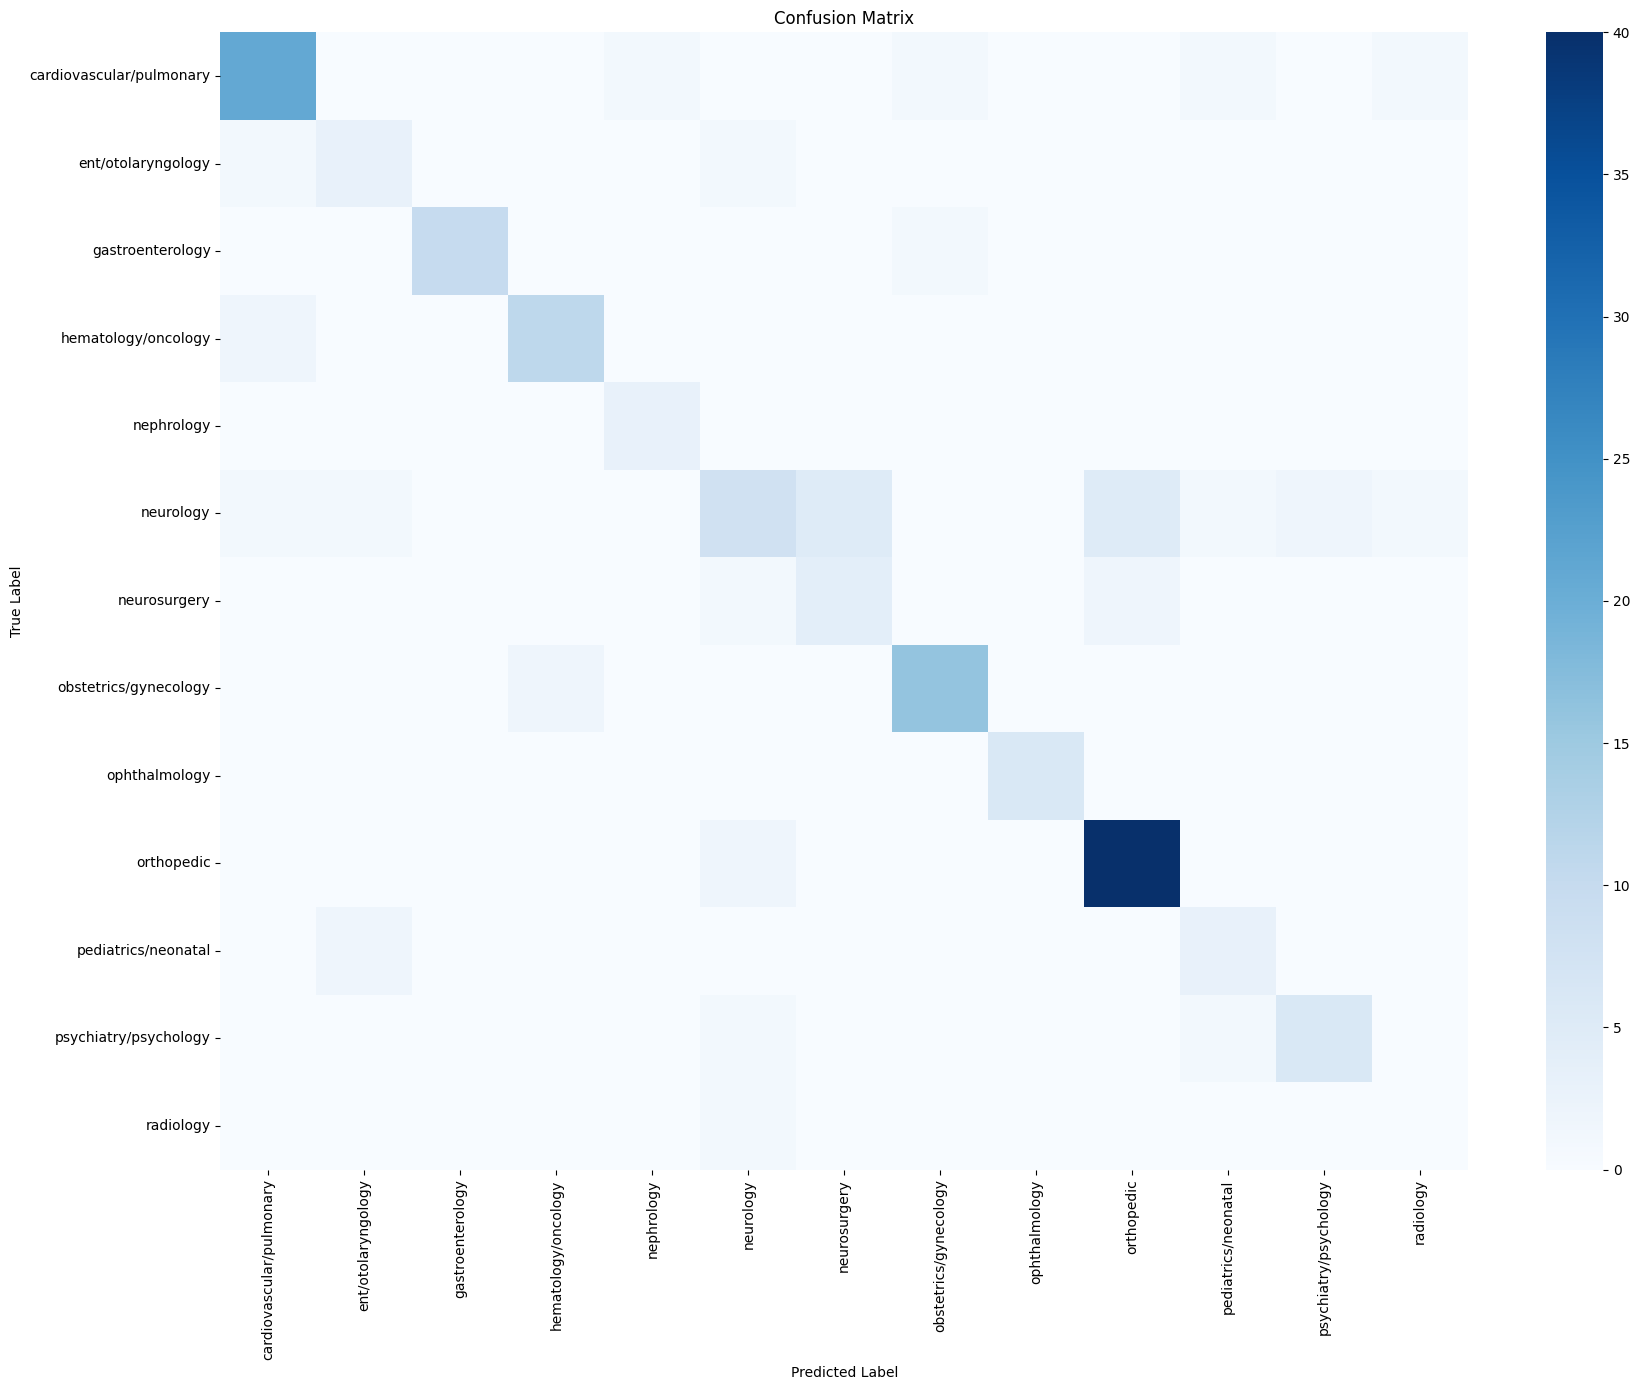


--- examples ---

Example 1:
Transcription:
INDICATIONS FOR PROCEDURE:, This is a 61-year-old, white male with onset of chest pain at 04: 30 this morning, with history of on and off chest discomfort over the past several days. CPK is already over 1000. There is ST elevation in leads II and aVF, as well as a Q wave. The chest pain is now gone, mild residual shortness of breath, no orthopnea. Cardiac monitor shows resolution of ST elevation lead III.,DESCRIPTION OF PROCEDURE:, Following sterile prep and drape of the right groin, installation of 1% Xylocaine anesthesia, the right common femoral artery was percutaneously entered and 6-French sheath inserted. ACT approximately 165 seconds on heparin. Borderline hypotension 250 mL fluid bolus given and nitroglycerin patch removed. Selective left and right coronary injections performed using Judkins coronary catheters with a 6-French pigtail catheter used to obtain left ventricular pressures and left ventriculography. Left pullback pressure.

In [3]:
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np
import re

# example
examples_to_show = 5  
example_results = []

# Alpaca prompt 템플릿
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

instruction = "Classify the following medical transcription into the correct medical specialty."

# 라벨 전처리 함수
def normalize_label(label):
    return label.lower().replace("-", "/").replace(" / ", "/").strip()

# 라벨 리스트 및 매핑
label_list = [
    'Cardiovascular / Pulmonary',
    'Orthopedic',
    'Nephrology',
    'Obstetrics / Gynecology',
    'Ophthalmology',
    'Gastroenterology',
    'Neurology',
    'ENT - Otolaryngology',
    'Psychiatry / Psychology',
    'Pediatrics / Neonatal',
    'Neurosurgery',
    'Hematology / Oncology',
    'Radiology'
]

# 정규화된 라벨 맵
normalized_label_map = {
    normalize_label(label): label for label in label_list
}

# 수정된 라벨 추출 함수 (부분 일치 허용)
def extract_label_from_response(response):
    response_lower = response.lower()

    for norm_label, full_label in normalized_label_map.items():
        # ENT - Otolaryngology는 otolaryngology 단어가 있을 때만
        if norm_label == "ent/otolaryngology":
            if "otolaryngology" in response_lower:
                return norm_label
            else:
                continue

        # 일반적인 경우: 전체 또는 하위 항목 포함되면 인식
        if norm_label in response_lower:
            return norm_label

        sub_labels = norm_label.split('/')
        for sub in sub_labels:
            if sub.strip() in response_lower:
                return norm_label

    return ""

MAX_INPUT_TOKENS = 4096

labels, preds = [], []

# 정규화된 클래스 라벨 목록
all_classes = sorted(list({normalize_label(x["medical_specialty"]) for x in test_dataset}))

for example in tqdm(test_dataset):
    transcription = example["transcription"]
    true_label = normalize_label(example["medical_specialty"])
    labels.append(true_label)

    prompt = alpaca_prompt.format(instruction, transcription, "")

    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=MAX_INPUT_TOKENS).to("cuda")

    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=64, use_cache=True)
    output_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    response = output_text.split("### Response:")[-1].strip().split("\n")[0]
    pred = extract_label_from_response(response)
    preds.append(pred)

    if len(example_results) < examples_to_show:
        example_results.append({
            "transcription": transcription,
            "true_label": true_label,
            "predicted_label": pred,
            "model_response": response,
        })

# 정확도 및 리포트 출력
print("✅ Accuracy:", accuracy_score(labels, preds))
print("\n📄 Classification Report:")
print(classification_report(labels, preds, labels=all_classes))

# Confusion matrix
cm = confusion_matrix(labels, preds, labels=all_classes)

plt.figure(figsize=(18, 14))
sns.heatmap(cm, xticklabels=all_classes, yticklabels=all_classes, annot=False, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 예시 결과 출력
print("\n--- examples ---")
for i, r in enumerate(example_results, 1):
    print(f"\nExample {i}:")
    print(f"Transcription:\n{r['transcription']}")
    print(f"True Label: {r['true_label']}")
    print(f"Predicted Label: {r['predicted_label']}")
    print(f"Model Response: {r['model_response']}")

# 맞춘 예시 출력
print("\n--- correctly predicted examples ---")
correct_examples = [r for r in example_results if r["true_label"] == r["predicted_label"]]

if not correct_examples:
    print("No correct predictions.")
else:
    for i, r in enumerate(correct_examples, 1):
        print(f"\nCorrect Example {i}:")
        print(f"Transcription:\n{r['transcription']}")
        print(f"True Label: {r['true_label']}")
        print(f"Predicted Label: {r['predicted_label']}")
        print(f"Model Response: {r['model_response']}")